Importing Needed Libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from gensim.models import Word2Vec
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [67]:
# Reading in datasets
train_df = pd.read_csv("movie_ratings_train.csv")
test_df = pd.read_csv("movie_ratings_test.csv")
movies_df = pd.read_csv("movies.csv")


# Data Cleaning & Transformations

In [68]:
# Check for duplicates in the training dataset
train_duplicates = train_df.duplicated()
print("Duplicate rows in training data:")
print(train_duplicates.value_counts())

Duplicate rows in training data:
False    90836
Name: count, dtype: int64


In [69]:
# Concatenating the datasets
full_df = pd.concat([train_df, test_df], ignore_index=True)

# View the combined data
full_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,81834,NaN,1493846730
100832,610,87232,NaN,1493845469
100833,610,91500,NaN,1493845427
100834,610,91658,NaN,1493845240


In [70]:
# Extract the movie name
movies_df['moviename'] = movies_df['title'].str.extract(r'^(.*?)(?:\s\((\d{4}(?:–\d{4})?)\))?$')[0]

# Extract the first year (only the first four digits if a range exists)
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})')[0]
movies_df.head()


,movieId,title,genres,moviename,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [71]:
# Creating dictionary to replace null values on year
movie_dict = {
    "Babylon 5":  1994,
    "Ready Player One": 2018,
    "Hyena Road": 2015,
    "The Adventures of Sherlock Holmes and Doctor Watson": 1979,
    "Nocturnal Animals": 2016,
    "Paterson": 2016,
    "Moonlight": 2016,
    "The OA": 1990,
    "Cosmos": 2019,
    "Maria Bamford: Old Baby": 2017,
    "Generation Iron 2": 2017,
    "Black Mirror": 2018,
}

In [72]:
# Replace missing years using the dictionary
movies_df['year'] = movies_df['moviename'].map(movie_dict).fillna(movies_df['year'])

# Convert Year to integers (replace NaN first, if necessary)
movies_df['year'] = movies_df['year'].astype(int)

In [73]:
merged_df = pd.merge(full_df, movies_df, on ='movieId', how='left') 

merged_df.head()

,userId,movieId,rating,timestamp,title,genres,moviename,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,Heat,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en),1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The",1995


In [74]:
# Dropping unnecessary columns
merged_df.drop(columns=['title', 'timestamp'], inplace= True, axis= 1 )

merged_df.head()

,userId,movieId,rating,genres,moviename,year
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,1,3,4.0,Comedy|Romance,Grumpier Old Men,1995
2,1,6,4.0,Action|Crime|Thriller,Heat,1995
3,1,47,5.0,Mystery|Thriller,Seven (a.k.a. Se7en),1995
4,1,50,5.0,Crime|Mystery|Thriller,"Usual Suspects, The",1995


In [75]:
# Checking for null values after cleaning and transforming data
merged_df.isnull().sum()

userId           0
movieId          0
rating       10000
genres           0
moviename        0
year             0
dtype: int64

Vector Embeddings

In [76]:
# Word2Vec for moviename
merged_df['moviename_tokens'] = merged_df['moviename'].str.lower().str.split()
merged_df['genres_tokens'] = merged_df['genres'].str.lower().str.split()
sentences = merged_df['moviename_tokens'].tolist() + merged_df['genres_tokens'].tolist()
model = Word2Vec(sentences, vector_size=15, window=5, min_count=1, workers=4)

# Aggregating embeddings for each record
def aggregate_embeddings(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:  # Check if the list is not empty
        return np.mean(vectors, axis=0)  # Aggregate using mean
    else:
        return np.zeros(model.vector_size)  # Handle cases where no tokens are in the model

merged_df['moviename_embedding'] = merged_df['moviename_tokens'].apply(lambda tokens: aggregate_embeddings(tokens, model))
merged_df['genres_embedding'] = merged_df['genres_tokens'].apply(lambda tokens: aggregate_embeddings(tokens, model))

# Convert embeddings to separate DataFrame
embedding_columns = ['embedding_' + str(i) for i in range(model.vector_size)]
moviename_embeddings_df = pd.DataFrame(merged_df['moviename_embedding'].tolist(), columns=['moviename_' + col for col in embedding_columns])
genres_embeddings_df = pd.DataFrame(merged_df['genres_embedding'].tolist(), columns=['genres_' + col for col in embedding_columns])

# Combine embeddings with original numerical columns
combined_df = pd.concat([merged_df[['rating', 'year']], moviename_embeddings_df, genres_embeddings_df], axis=1)


display(combined_df)

,rating,year,moviename_embedding_0,moviename_embedding_1,moviename_embedding_2,moviename_embedding_3,moviename_embedding_4,moviename_embedding_5,moviename_embedding_6,moviename_embedding_7,...,genres_embedding_5,genres_embedding_6,genres_embedding_7,genres_embedding_8,genres_embedding_9,genres_embedding_10,genres_embedding_11,genres_embedding_12,genres_embedding_13,genres_embedding_14
0,4.0,1995,-3.067749,-0.771409,3.301736,-3.494645,1.042338,0.468238,-0.322642,0.076268,...,-0.000154,-0.036322,-0.011507,0.047233,0.024908,-0.059207,-0.022757,0.015694,0.014253,-0.063093
1,4.0,1995,1.468275,0.578010,0.825346,-3.056963,-0.290390,-0.071899,2.017154,2.372319,...,-0.005710,0.018844,0.036010,0.047018,-0.038021,0.012392,0.040592,-0.031987,-0.020715,0.045318
2,4.0,1995,0.110653,0.148581,0.350345,-0.706225,-0.422196,-0.250710,0.326879,0.495466,...,0.030196,0.009562,-0.017999,-0.029112,-0.006880,0.009580,-0.017640,-0.047159,-0.052035,-0.060812
3,5.0,1995,-0.392756,-0.559024,3.240436,-3.629435,1.299975,-1.012388,1.520207,3.612851,...,-0.048597,-0.060266,0.038907,0.062608,0.023380,0.047259,-0.010453,0.052983,-0.063258,-0.053530
4,5.0,1995,-1.291711,-0.786474,1.554268,-1.122774,-1.645867,-1.405326,0.607294,1.356944,...,0.003992,0.063473,-0.007351,-0.062831,0.010723,0.041549,0.041882,0.027278,-0.037668,-0.002471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,NaN,2010,-0.726131,1.233335,2.811481,-4.369538,-0.232659,0.169614,0.856503,1.175276,...,-0.026695,-0.039154,-0.001292,0.066217,0.050780,0.022305,0.043891,-0.056779,-0.017806,0.050833
100832,NaN,2011,-1.898092,1.263718,2.222522,-0.629783,1.191768,-0.680842,1.126011,-0.416718,...,0.033963,-0.042920,0.055315,-0.012158,-0.065592,0.050308,0.016466,0.043336,-0.001524,0.011664
100833,NaN,2012,-0.530844,-0.080715,1.553438,-0.871598,-1.083272,-0.825487,0.832509,0.797860,...,0.056361,-0.001255,0.015098,-0.023648,-0.027949,-0.057466,-0.052353,-0.060528,-0.039804,0.056586
100834,NaN,2011,0.505495,-1.646519,0.656398,-2.493641,-1.822804,-2.580944,0.250896,0.476898,...,-0.030063,0.038011,0.061200,-0.027332,0.053098,0.035836,0.039194,0.003417,0.054754,-0.046794


In [77]:
# creating condition to separate into training and test datasets
condition = combined_df['rating'].isnull()

In [78]:
# separating into train and test datas based on condition 
train_data = combined_df[~condition]

test_data = combined_df[condition]

In [79]:
# Grouping predictors and response variables
X = train_data.drop(columns=['rating'])
y = train_data['rating']

In [80]:
# Step 1: Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Model One: Random Forest

In [81]:
# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Step 3: Predict on the training set
y_train_pred = model.predict(X_train)

# Step 4: Predict on the validation set
y_val_pred = model.predict(X_valid)

# Step 5: Calculate the MSE
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_valid, y_val_pred)

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Training MSE: 0.757744478203909
Validation MSE: 0.9341488489540484


In [82]:
# dropping response variable in test data
test_data.drop(columns="rating", axis=1, inplace=True)

C:\Users\ekf98\AppData\Local\Temp\ipykernel_8732\2330697028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns="rating", axis=1, inplace=True)


The predictions below resulted in a 91 test RMSE on Mihai's leaderboard.

In [83]:
# Step 4: Predict on the test set
y_pred_test = model.predict(test_data)

rounded_test_predictions = y_pred_test.tolist()

# Print the final binary predictions
print(rounded_test_predictions)

[3.65842203038328, 3.35181046087105, 3.420020613511287, 4.228505692262094, 4.1784168125614425, 3.9479458690338896, 3.965146412121202, 4.018214836158887, 3.5622221423316027, 3.346883359818737, 3.6588112604852374, 3.8579051496247536, 3.29739029821685, 3.6687334255060065, 4.199125033043056, 3.773214440147891, 3.110684771989453, 3.1719260334753714, 3.9651005285909617, 3.809747406732115, 4.320928830508117, 3.4554725272172506, 3.2722295014025993, 3.7572131071218346, 4.036445548891617, 4.173839073991132, 3.4562073942503186, 3.318205595586287, 3.85329432359347, 3.951689750869009, 3.9673457616079393, 3.9449046080569996, 4.296630707124203, 4.089402902078032, 4.278937083629882, 4.084800445460536, 4.018214836158887, 3.5464559021281725, 3.5622221423316027, 4.1248385307390745, 3.943504843058941, 3.8579051496247536, 4.092880319104336, 3.972566328291088, 3.773214440147891, 3.199029653757711, 3.409226034064925, 3.190242680698042, 3.5415921490921187, 3.829287017526965, 4.189119329394043, 3.8395784643439

# Model Two: Neural Networks

Epoch 1/20


c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5906.2427 - val_loss: 5.7055
Epoch 2/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 18.0960 - val_loss: 4.5569
Epoch 3/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.1379 - val_loss: 2.8400
Epoch 4/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.4193 - val_loss: 1.9993
Epoch 5/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.1555 - val_loss: 1.3107
Epoch 6/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4410 - val_loss: 1.1243
Epoch 7/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2225 - val_loss: 1.0814
Epoch 8/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1465 - val_loss: 1.0801
Epoch 9/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1591 - val_loss: 1.0798
Epoch 10/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1144 - val_loss: 1.0796
Epoch 11/20
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0959 - val_loss: 1.0797
Epoch 12/20
1454/1454 ━━━━━━━━━━━━━━━

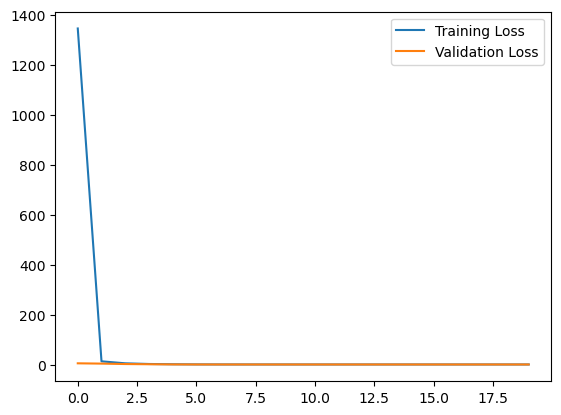

2271/2271 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step


In [84]:
model = Sequential([
    Dense(units=128, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=l2(0)),  # L2 regularization
    Dropout(0.5),  # Dropout with 30% rate
    Dense(units=64, activation='relu', kernel_regularizer=l2(0)),
    Dropout(0.5),
    Dense(units=32, activation='relu', kernel_regularizer=l2(0)),
    Dropout(0.5),
    Dense(units=1, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train,  validation_data=(X_valid, y_valid), epochs=20, batch_size=50, verbose=1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#Predict on the training set
y_train_pred = model.predict(X_train)

# Make predictions
y_val_pred = model.predict(X_valid)

In [85]:
# Step 5: Calculate the MSE
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_valid, y_val_pred)

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Training MSE: 1.101714302219235
Validation MSE: 1.0794845721660136


The predictions on the test data set for the neural networks obtained a test RMSE of 1.06 on Mihai's leaderboard

In [86]:
# Step 4: Predict on the test set
y_pred_test = model.predict(test_data)

rounded_test_predictions = y_pred_test.tolist()

# Print the final binary predictions
print(rounded_test_predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
[[3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111183166504], [3.4966111

Given Random forest performs better than the Neural Networks, the Random forest is used as our final model to predict the movie-user ratings. 